In [1]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline  

# Estimating ECS from recent transient observations

We assume a simple energy balance model of the climate system, where an external forcing $\Delta F$ leads to a radiative response and an energy imbalance at the top of the atmosphere
$$\Delta F = \lambda \Delta T + \Delta Q$$
The quantity $\lambda$ represents the climate \emph{feedback} and here, is assumed to be constant in time (we'll revisit this likely flawed assumption later).  

Equilibrium climate sensitivity $S$ is defined as the temperature change at equilibrium in response to a doubling of CO$_2$.  By definition, at equilibrium we have $\Delta Q =0$ and 
$$S = \frac{F_{2\times CO_2} }{\lambda}$$

If (and this is a big if) the feedbacks are constant in time, then the estimated sensitivity from historical observations 
$$S_{hist} = \frac{F_{2\times CO_2} \Delta T}{\Delta F - \Delta Q}$$
is equal to the equilibrium sensitivity ($S=S_{hist}$).



We have observations of the temperature change $\Delta T$ and the rate of ocean heat uptake $\Delta Q$ (roughly equivalent to the TOA imbalance because the land heat capacity is negligible).  We can estimate the radiative forcing $\Delta F$ from inventories of CO$_2$ emissons and aerosol burden.  The uncertainites in these quantities are (initially) assumed to be Gaussian).


In [2]:
nsamp=100
dT = np.random.normal(loc=0.91,scale=0.11/1.96,size=nsamp)
dQ = np.random.normal(0.61,0.14/1.96,size=nsamp)

Now, take samples of F and $F_{2\times CO_2}$

In [3]:
dF2xCO2_dist =np.random.normal(3.8,0.74/1.96,size=nsamp)
F2x=3.8
dF = dF2xCO2_dist - np.random.normal(1.46,0.77/1.96,size=nsamp) 

In [10]:
simple_model=F2x*dT/(dF-dQ)
ECS_best_guess=np.median(test)
print("Best guess ECS = "+str(ECS_best_guess))

Best guess ECS = 1.991609314359853


Collate into a single array:

x=$\Delta F$

y=$\Delta Q$

z=$\Delta T$

In [11]:
values = np.zeros((3,nsamp))
values[2]=dT
values[0]=dF
values[1]=dQ

Now calculate a kernel density estimate from these samples

In [12]:
kde = stats.gaussian_kde(values)

Evaluate the kernel density at the samples in order to plot

Text(0.5, 0, '$\\Delta$T')

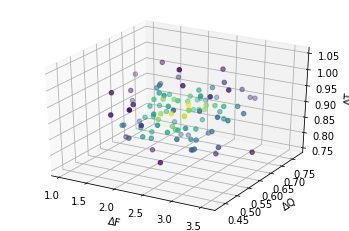

In [13]:
density = kde(values)
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.scatter(dF, dQ, dT, c=density)
ax.set_xlabel(r'$\Delta$F')
ax.set_ylabel(r'$\Delta$Q')
ax.set_zlabel(r'$\Delta$T')

If $S_{hist}$ is simply related to these quantities through
$$S_{hist} = \frac{F_{2\times CO_2} \Delta T}{\Delta F - \Delta Q}$$
then each value of $S_{hist}$ uniquely defines a plane in $(\Delta F, \Delta Q, \Delta T)$ space.


In [27]:
%%capture
def plot_plane(Shist,ax=plt.gca()):
    Fs = np.linspace(np.min(dF),np.max(dF),nsamp)
    Qs = np.linspace(.3,.9,nsamp)
    xx,yy=np.meshgrid(Fs,Qs)
    zz = Shist/3.8*(xx-yy)
    ax.plot_surface(xx,yy,zz,alpha=.3,label="Shist = "+str(Shist))
def plot_plane_F2x_uncertainty(Shist,ax=plt.gca()):
    Fs = np.linspace(np.min(dF),np.max(dF),nsamp)
    Qs = np.linspace(.3,.9,nsamp)
    xx,yy=np.meshgrid(Fs,Qs)
    zz = Shist/dF2xCO2_dist*(xx-yy)
    ax.plot_surface(xx,yy,zz,alpha=.3,label="Shist = "+str(Shist))

The value of $S_{hist}$ determines the steepness of the plane.  If $S_{hist}=1$, the plane slices through the bottom of the 3D distribution.  If $S_{hist}=5$, the plane grazes the top.  But if $S_{hist}=1.5$, the plane intersects the densest area.  

(0.5, 1.5)

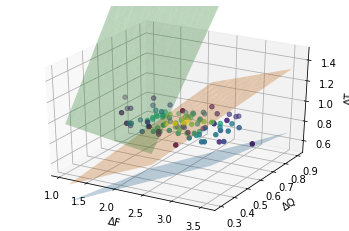

In [39]:
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.scatter(dF, dQ, dT, c=density)
ax.set_xlabel(r'$\Delta$F')
ax.set_ylabel(r'$\Delta$Q')
ax.set_zlabel(r'$\Delta$T')
plot_plane(1,ax)
plot_plane(1.9,ax)

plot_plane(5,ax)
ax.set_zlim(.5,1.5)


The likelihood of a particular $S_{hist}$ is the area of the intersection of the plane defined by $S_{hist}$ and the 3D kernel density.  Note that here, we're not $sampling$ values of $\Delta F$ or $\Delta Q$, we're just using them to define the plane.

In [30]:
likelihood = []
Fs = np.linspace(np.min(dF),np.max(dF),nsamp)
Qs = np.linspace(.3,.9,nsamp)
Shist_possibilities = np.linspace(.1,5,num=nsamp)
for Shist in Shist_possibilities:
    #the plane is given by
    #Ts = Shist * (Fs-Qs)/dF2xCO2_dist
    Ts=Shist*(Fs-Qs)/3.8
    #now evaluate the kernel density on the plane using kde
    Svals=np.vstack((Fs,Qs,Ts))
    likelihood += [np.sum(kde(Svals))]

Now plot the likelihood of different values of $S_{hist}$

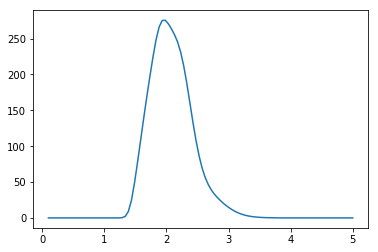

In [31]:
plt.plot(Shist_possibilities,likelihood)

In [32]:
Shist_possibilities[np.argmax(likelihood)]

1.9808080808080812

# Last Glacial Maximum

We assume the climate is in equilibrium ($\Delta Q = 0$.)  If there is no state dependence, then we can write 
$$S=\frac{F_{2\times CO_2} \Delta T}{\Delta F}.$$

In [12]:
%%capture
def plot_line(S):
    Ts = np.linspace(-10,0,nsamp)
    
    plt.plot(Ts,Ts*F2x/S)
    
    

However, it is possible that the feedbacks may be stronger or weaker in a cold climate.  To reflect this, we can expand 
$$\Delta F = \frac{\partial F}{\partial T}\Delta T + \frac{1}{2}\frac{\partial^2 F}{\partial T^2} \Delta T^2$$
and set $\alpha=\frac{1}{2}\frac{\partial^2 F}{\partial T^2}$.  In this case, we have 
$$\Delta T=\frac{\Delta F}{\lambda + \alpha \Delta T}$$

In [42]:
%%capture
def plot_complex_line(S,alpha,ax=plt.gca(),**kwargs):
    Ts = np.linspace(-10,0,nsamp)
    
    plt.plot(Ts,Ts*(F2x+alpha*Ts)/S,**kwargs)
    

From paleo: We can reconstruct carbon dioxide (and thus forcing) and temperature.  
Last glacial to interglacial global mean temperature estimates range from 3K to 7K, so we'll take 
$$\Delta T_{LGM} = N(5,1). $$
Let's also assume that forcing is 
$$\Delta F_{LGM} = N(-8.8,2.0)$$
Once again, we can calculate the kernel density. For a given ECS and 

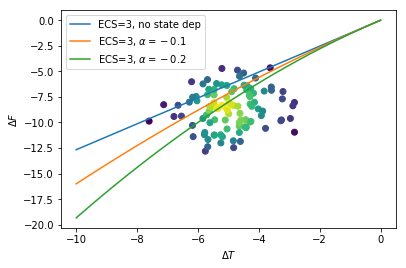

In [53]:
nsamp=100
dT_LGM = np.random.normal(loc=-5.0,scale=1.0,size=nsamp)
dF_LGM = np.random.normal(loc=-8.8,scale=2.0,size=nsamp)
values_LGM = np.zeros((2,nsamp))
values_LGM[0]=dT_LGM
values_LGM[1]=dF_LGM
kde_LGM = stats.gaussian_kde(values_LGM)
density_LGM = kde_LGM(values_LGM)
ax=plt.subplot(111)
ax.scatter(dT_LGM,dF_LGM,c=density_LGM)
ax.set_ylabel(r"$\Delta F$")
ax.set_xlabel(r"$\Delta T$")
plot_complex_line(3,0,ax=ax,label="ECS=3, no state dep")

plot_complex_line(3,-.1,label=r"ECS=3, $\alpha=-0.1$")
plot_complex_line(3,-.2,label=r"ECS=3, $\alpha=-0.2$")
plt.legend()

In [54]:
def get_LGM_likelihood(alpha):
    likelihood_LGM = []

    Ts = np.linspace(-10,0,nsamp)
    S_possibilities = np.linspace(.1,8,num=nsamp)
    for S in S_possibilities:
        #the plane is given by
        Fs=Ts*(F2x+alpha*Ts)/S
        #now evaluate the kernel density on the plane using kde
        Svals=np.vstack((Ts,Fs))
        likelihood_LGM += [np.sum(kde_LGM(Svals))]
    plt.plot(S_possibilities,likelihood_LGM,label=r"$\alpha=$"+str(alpha))
    plt.xlabel("S")
    plt.ylabel("Likelihood")


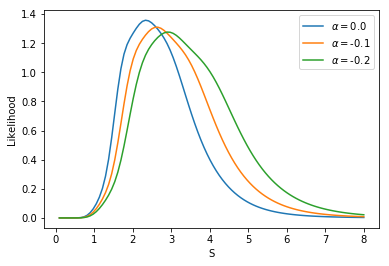

In [55]:
get_LGM_likelihood(0.)
get_LGM_likelihood(alpha=-0.1)
get_LGM_likelihood(alpha=-0.2)
plt.legend()

# Inferring ECS from the Pliocene

The mid-Pliocene , which occured 3.3-3.0 MYa, is the most recent analogue for a hot, high-CO$_2$ climate.  We take 
$$\Delta T_{pliocene} = N(3,1)$$
and 
$$\Delta CO2_{pliocene} = N(375,25)$$

In [59]:
%%capture
def plot_line_pliocene(S,ESS,ax=plt.gca()):
    Fs = np.linspace(0,4,num=nsamp)
    
    plt.plot(Fs,(S/F2x)*Fs*(1+ESS))


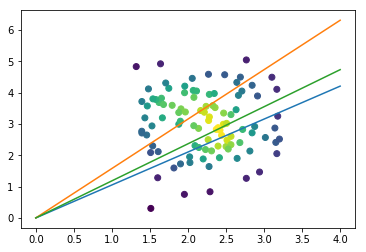

In [62]:
dT_pliocene = np.random.normal(loc=3.0,scale=1.0,size=nsamp)
dCO2_pliocene=np.random.normal(375.,scale=25.0,size=nsamp)
dFCO2_pliocene=np.log(dCO2_pliocene/280.)/np.log(2.0)*F2x
dF_pliocene=dFCO2_pliocene*(1+np.random.normal(.4,scale=0.1,size=nsamp))
values_pliocene = np.zeros((2,nsamp))
values_pliocene[1]=dT_pliocene
values_pliocene[0]=dF_pliocene
kde_pliocene = stats.gaussian_kde(values_pliocene)
density_pliocene = kde_pliocene(values_pliocene)
plt.scatter(dF_pliocene,dT_pliocene,c=density_pliocene)
plot_line_pliocene(4,0)
plot_line_pliocene(4,.5)
plot_line_pliocene(3,.5)

In [63]:
np.max(dF_pliocene)

3.2019326412168128

In [70]:
%%capture
def get_pliocene_likelihood(ESS):
    likelihood_pliocene = []
    Fs = np.linspace(0,5,nsamp)

    S_possibilities = np.linspace(.1,10,num=nsamp)
    for S in S_possibilities:
        #the plane is given by
        Ts =(S/F2x)*Fs*(1+ESS)
        #now evaluate the kernel density on the plane using kde
        Svals=np.vstack((Fs,Ts))
        likelihood_pliocene += [np.sum(kde_pliocene(Svals))/np.sum(density_pliocene)]
    plt.plot(S_possibilities,likelihood_pliocene,label="ESS ="+str(ESS))

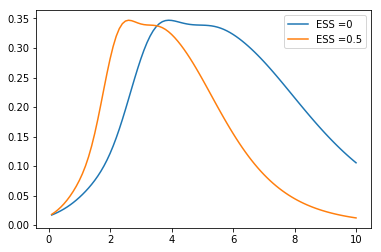

In [72]:
get_pliocene_likelihood(0)
get_pliocene_likelihood(.5)
plt.legend()